In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import glob
import os
import pandas as pd
import numpy as np
import csv
import re
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import statsmodels.api as sm
import os

C:\Users\DaBoss\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Set up the Data

In [4]:
data_folder = "./testerCopy"

Change all files to csv

In [12]:
# TODO: Make the '*' argument only capture files with no extension, i.e no '.'
import re

regex = r"([a-zA-Z0-9])"

for filename in glob.iglob(os.path.join(data_folder, 'r')):
    #os.rename(filename, filename + '.csv')
    print(filename)

#for filename in glob.iglob(os.path.join(data_folder, '*')):
#    os.rename(filename, filename + '.csv')
#    print(filename)

Create a data frame from all of the numerical data in the csv by spliting by exclamation points and only selects rows from csv that are more than 100 character because all of the levels data are extremely long.


In [33]:
lesstemplist = []
for filename in glob.iglob(data_folder + "/*.csv"):
#     print(filename)
    temp = open(filename, 'r')
    temp2 = temp.read().splitlines()
    for i in range(len(temp2)):
        if len(temp2[i])>1000:
            vabs = temp2[i].split('!')
            lesstemplist.append(vabs)

### Create Initial the data frame

In [38]:
#TODO: Consider a rename to mouse_data.  If we move to a separate and merge model.
df = pd.DataFrame(lesstemplist,columns=['accratio', 'Xcord', 'Ycord','Timemousecords','timestimsarrive','difficultylevel','stimsclicked','stimsshown'])

In [41]:
df.head()

,accratio,Xcord,Ycord,Timemousecords,timestimsarrive,difficultylevel,stimsclicked,stimsshown
0,"""0.25316455696202533","386,401,420,445,501,514,528,535,538,540,540,54...","615,586,569,546,478,465,452,440,432,428,423,41...","1520885083783,1520885083796,1520885083811,1520...","1520885082141,1520885082798,1520885083456,1520...",3,20,"79"""
1,"""0.2235294117647059","386,401,420,445,501,514,528,535,538,540,540,54...","615,586,569,546,478,465,452,440,432,428,423,41...","1520885083783,1520885083796,1520885083811,1520...","1520885082141,1520885082798,1520885083456,1520...",4,19,"85"""
2,"""0.14772727272727273","386,401,420,445,501,514,528,535,538,540,540,54...","615,586,569,546,478,465,452,440,432,428,423,41...","1520885083783,1520885083796,1520885083811,1520...","1520885082141,1520885082798,1520885083456,1520...",5,13,"88"""
3,"""0.14942528735632185","386,401,420,445,501,514,528,535,538,540,540,54...","615,586,569,546,478,465,452,440,432,428,423,41...","1520885083783,1520885083796,1520885083811,1520...","1520885082141,1520885082798,1520885083456,1520...",6,13,"87"""
4,"""0.1348314606741573","386,401,420,445,501,514,528,535,538,540,540,54...","615,586,569,546,478,465,452,440,432,428,423,41...","1520885083783,1520885083796,1520885083811,1520...","1520885082141,1520885082798,1520885083456,1520...",7,12,"89"""


Add an id column to the dataframe and populate it.
Find the id string; if there is none, fill the id field with "anon".
TOOD: Update csv so that the id is always the last line of the code.  Then this should become just a few lines.

Currently: Here we add in ids by creating a new dataframe for ids. 
sometimes id and the final questionairre answers get reversed in order so we perform a swap if the the last element is longer than the second to last element
we also create the id anon for any rows csv that down have an id becuase the partivciapnt did not reach the end of the experiment.

In [45]:
ids = []
for filename in glob.iglob(data_folder + "/*.csv*"):
    temp = open(filename, 'r')
    temp2 = temp.read().splitlines()
    if len(temp2[-1]) > len(temp2[-2]):
        #here were swaping if the final questionairre and id are in the wrong order
        x = temp2[-1]
        temp2[-1] = temp2[-2]
        temp2[-2] = temp2[-1]
        for i in range(len(temp2)):
            if len(temp2[i])>1000:
                if len(temp2[-1]) > 25:
                    ids.append("anon")
                else:
                    ids.append(temp2[-1])
    else:
        for i in range(len(temp2)):
            if len(temp2[i])>1000:
                if len(temp2[-1]) > 25:
                    ids.append("anon")
                else:
                    ids.append(temp2[-1])
se = pd.Series(ids)
df['IDs'] = se.values
# TODO: Rename to ID and make it the first coulumn

In [46]:
# df.head()

### Add the survey data to a new frame
Here we add in the questionairre data the same way as we have with everything else. the questionairre data comes in a bit messy so we also trim of some of the exra bits like the equals signs used as delimiters.

In [49]:
# TODO: Rename to questionairre_data, and populate it based on "undefined" being at the start.  But TODO2: If there is a way to use a meaningful phrase rather than undefined, that would be good.
# For line in lines, if line.startswith("undefined)....

expQs = []
for filename in glob.iglob(data_folder+"/.csv*"):
    temp = open(filename, 'r')
    temp2 = temp.read().splitlines()
    #numlines += len(temp2)
    templist = []
    for i in range(len(temp2)):
        if (len(temp2[i])<50) & (len(temp2[i])>15):
            vabs = temp2[i].split(',')
            newvabs = [x[-1] for x in vabs]
            finalvabs = newvabs[:3]
            expQs.append(finalvabs)
            
# TODO: No need for new files. Just create the question df and mutate it directly in here            
df2= pd.DataFrame(expQs,columns=['Q1','Q2','Q3'])

df3 = pd.concat([df, df2], axis=1)

##blank out unfinished Questionairres

df4 = df3
mask = df4.Q3 == '='
column_name1 = 'Q3'
df4.loc[mask, ['Q1','Q2','Q3']] = 0

In [50]:
df4.head()

,accratio,Xcord,Ycord,Timemousecords,timestimsarrive,difficultylevel,stimsclicked,stimsshown,IDs,Q1,Q2,Q3
0,"""0.25316455696202533","386,401,420,445,501,514,528,535,538,540,540,54...","615,586,569,546,478,465,452,440,432,428,423,41...","1520885083783,1520885083796,1520885083811,1520...","1520885082141,1520885082798,1520885083456,1520...",3,20,"79""","""C3X8gydKHOEj""",NaN,NaN,NaN
1,"""0.2235294117647059","386,401,420,445,501,514,528,535,538,540,540,54...","615,586,569,546,478,465,452,440,432,428,423,41...","1520885083783,1520885083796,1520885083811,1520...","1520885082141,1520885082798,1520885083456,1520...",4,19,"85""","""C3X8gydKHOEj""",NaN,NaN,NaN
2,"""0.14772727272727273","386,401,420,445,501,514,528,535,538,540,540,54...","615,586,569,546,478,465,452,440,432,428,423,41...","1520885083783,1520885083796,1520885083811,1520...","1520885082141,1520885082798,1520885083456,1520...",5,13,"88""","""C3X8gydKHOEj""",NaN,NaN,NaN
3,"""0.14942528735632185","386,401,420,445,501,514,528,535,538,540,540,54...","615,586,569,546,478,465,452,440,432,428,423,41...","1520885083783,1520885083796,1520885083811,1520...","1520885082141,1520885082798,1520885083456,1520...",6,13,"87""","""C3X8gydKHOEj""",NaN,NaN,NaN
4,"""0.1348314606741573","386,401,420,445,501,514,528,535,538,540,540,54...","615,586,569,546,478,465,452,440,432,428,423,41...","1520885083783,1520885083796,1520885083811,1520...","1520885082141,1520885082798,1520885083456,1520...",7,12,"89""","""C3X8gydKHOEj""",NaN,NaN,NaN


In [51]:
# Get rid of quotes around things
#
#df.applymap(lambda x: x.replace('"', ''))
for i, col in enumerate(df.columns):
    df4.iloc[:, i] = df.iloc[:, i].str.replace('"', '')

In [53]:
# df4.head()

### Analyze Dataa

#### Exploratory: Display the mouse-trajectory  for a single row
TODO: Add color to dots that changes over time so you can see which paterns are from beginning and which are from end

In [56]:
# Explore a single path
row_num = 10

In [57]:
#currently prints xs and ys from row zero 
xs = [int(i)-100 for i in df4.at[row_num,'Xcord'].split(',')]  
ys = [int(i) for i in df4.at[row_num,'Ycord'].split(',')]  

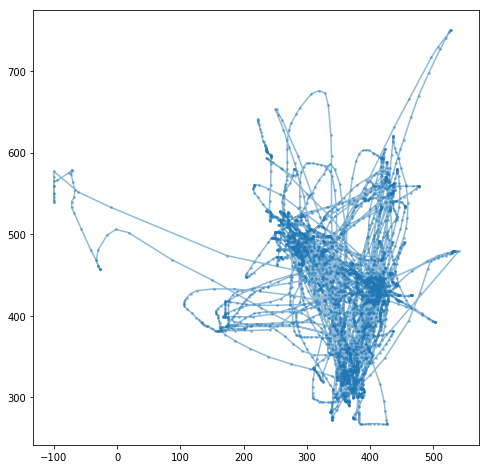

In [58]:
plt.figure(1,figsize=(8,8))
#im = plt.imread("C:/Users/DaBoss/DocumentsGitHub/clickdamole/images/moles.png")
#implot = plt.imshow(im, alpha=.5)
plt.plot(xs, ys, alpha=.5)
plt.scatter(xs, ys, alpha=.4, s=3)

#### Simple Regression

In [83]:
numeric_table = df4.copy()
numeric_table = numeric_table.drop(['Xcord','Ycord', 'Timemousecords', 'timestimsarrive','IDs'],axis=1)
numeric_table = numeric_table.convert_objects(convert_numeric=True)
# TODO: Use pd.to_numeric above

/Users/jyoshimi/miniconda2/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  app.launch_new_instance()


Set up model

In [85]:
target = pd.DataFrame(numeric_table.Q2, columns=['Q2'])
X=numeric_table['accratio']
x=X.tolist()
Y=target['Q2']
y=Y.tolist()
model = sm.OLS(y, x).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                         nan
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Tue, 03 Apr 2018   Prob (F-statistic):                nan
Time:                        14:38:38   Log-Likelihood:                    nan
No. Observations:                 164   AIC:                               nan
Df Residuals:                     163   BIC:                               nan
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1                nan        nan        nan        nan         nan         nan
==============================================================================
Omnibus:                          nan   Durbin-Watson:                     nan
Prob(Omnibus):                    nan   Jarque-Bera (JB):                  nan
Skew:                             nan   Prob(JB):                          nan
Kurtosis:                         nan   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

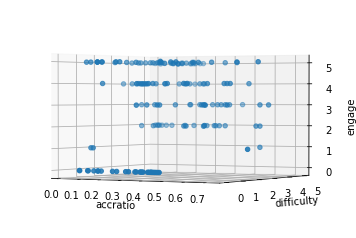

In [11]:
#for color but havent done this yet
engagement = allnumdf['Q2'].tolist()
difficulty = allnumdf['Q1'].tolist()
accuracy = allnumdf['accratio'].tolist()
threedee = plt.figure().gca(projection='3d')
threedee.scatter(accuracy, difficulty, engagement)
threedee.set_xlabel('accratio')
threedee.set_zlabel('engage')
threedee.set_ylabel('difficulty')
threedee.view_init(azim=0)
threedee.view_init(elev=1)

plt.show()


In [12]:
##trying to fit m,ultiple regression
import statsmodels.formula.api as smf

mX = allnumdf[['Q1', 'accratio']]

my = allnumdf['Q2']
## fit a OLS model with intercept on TV and Radio

mX = sm.add_constant(X)

Mest = sm.OLS(my, mX).fit()
Mest = smf.ols(formula='Q2 ~ accratio * Q1', data=allnumdf).fit()

Mest.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     Q2   R-squared:                       0.378
Model:                            OLS   Adj. R-squared:                  0.366
Method:                 Least Squares   F-statistic:                     32.43
Date:                Fri, 23 Mar 2018   Prob (F-statistic):           1.98e-16
Time:                        01:46:40   Log-Likelihood:                -286.66
No. Observations:                 164   AIC:                             581.3
Df Residuals:                     160   BIC:                             593.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       2.5496      0.449      5.673      0.000       1.662       3.437
accratio       -4.1667      1.544     -2.698      0.008      -7.217      -1.117
Q1              0.5300      0.147      3.615      0.000       0.240       0.820
accratio:Q1     0.4648      0.495      0.940      0.349      -0.512       1.441
==============================================================================
Omnibus:                       15.288   Durbin-Watson:                   0.573
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                5.348
Skew:                           0.068   Prob(JB):                       0.0690
Kurtosis:                       2.126   Cond. No.                         51.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

TODO: Add notes about dependent variables
Suggestions.  

error rate / number of misses

how_long (num points)
mean velocity (between point distance). Later color with velocity.
mean acceleration (differences between successive velocity values). Later color with acceleration.
curvature: https://stackoverflow.com/questions/27095399/how-do-i-calculate-radius-of-curvature-from-discrete-samples

look at the open sesame library for what they have

check those spivey notes



In [14]:
row_number = 10
xs = [int(i)-100 for i in df4.at[row_number,'Xcord'].split(',')]  
ys = [int(i) for i in df4.at[row_number,'Ycord'].split(',')] 

velocX = []

for i in range(0,len(xs)-1):
    velocX.append(xs[i] - xs[i + 1])

numpy.mean(velocX)

NameError: name 'df4' is not defined

In [ ]:
import math

row_number = 11
xs = [int(i)-100 for i in df4.at[row_number,'Xcord'].split(',')]  
ys = [int(i) for i in df4.at[row_number,'Ycord'].split(',')] 

velocX = []

for i in range(0,len(xs)-1):
    velocX.append(xs[i] - xs[i + 1])

#np.mean(velocX)

velocY = []

for i in range(0,len(ys)-1):
    velocY.append(ys[i] - ys[i + 1])
#np.mean(velocY)

velocity = []
for i in range(0,len(velocY)):
    velocity.append((velocX[i]**2 + velocY[i]**2)**.5)
    #print((velocX[i]**2 + velocY[i]**2)**.5)

print(velocX[0:5])
print(velocY[0:5])
print(velocity[0:5])

print((-3**2 + 5**2)**.5)
print((velocX[1]**2 + velocY[1]**2)**.5)

velocity1 = []
for i in range(0,len(velocY)):
    velocity1.append(math.sqrt(math.pow(velocX[i], 2) + math.pow(velocY[i], 2)))
    #print((velocX[i]**2 + velocY[i]**2)**.5)

print(velocX[0:5])
print(velocY[0:5])
print(velocity[0:5])

print(math.sqrt(math.pow(-3, 2) + math.pow(5, 2)))
print(math.sqrt(math.pow(velocX[1], 2) + math.pow(velocY[1], 2)))


In [ ]:
velocities = []
for x in range(0,len((df4.index)-1)):
    xs = [int(i) for i in df4.at[x,'Xcord'].split(',')]  
    ys = [int(i) for i in df4.at[x,'Ycord'].split(',')] 
    velocity1 = []
    for i in range(0,len(velocY)):
        velocity1.append(math.sqrt(math.pow(velocX[i], 2) + math.pow(velocY[i], 2)))
    velocities.append(velocity1)

series = pd.Series(velocities)
df4['velocities'] = series.values
df4.head()